In [1]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

In [4]:
prom_file_path = "r14n17_tb.parquet"

In [5]:
prom_df = pd.read_parquet(prom_file_path)

In [22]:
prom_df

,node_load15,node_load5,node_load1,node_memory_Active_bytes,nvidia_gpu_power_usage_milliwatts-max,nvidia_gpu_temperature_celsius-max,isAnomaly
62233496,4.68,11.79,49.61,2.943042e+09,0.0,0,1
62233497,4.68,11.79,49.61,2.943042e+09,0.0,0,1
62233498,9.11,24.43,86.80,2.942775e+09,0.0,0,1
62233499,9.11,24.43,86.80,2.942775e+09,0.0,0,1
62233500,13.40,35.86,109.33,2.942779e+09,0.0,0,1
...,...,...,...,...,...,...,...
62321735,6.06,6.43,7.44,6.790017e+09,0.0,0,0
62321736,6.13,6.64,7.96,7.545741e+09,0.0,0,0
62321737,6.13,6.64,7.96,7.545741e+09,0.0,0,0
62321738,6.37,7.30,10.27,6.114273e+10,0.0,0,0


In [21]:
correct_order = ['node_load15','node_load5','node_load1','node_memory_Active_bytes','nvidia_gpu_power_usage_milliwatts-max','nvidia_gpu_temperature_celsius-max', 'isAnomaly']
other_cols = [col for col in prom_df.columns if col not in correct_order]

prom_df = prom_df[correct_order + other_cols]

              precision    recall  f1-score   support

           0       1.00      0.04      0.08     58108
           1       0.35      1.00      0.52     30136

    accuracy                           0.37     88244
   macro avg       0.68      0.52      0.30     88244
weighted avg       0.78      0.37      0.23     88244

Confusion matrix:
 [[ 2286 55822]
 [    0 30136]]
ROC AUC Score: 0.5196702691539892


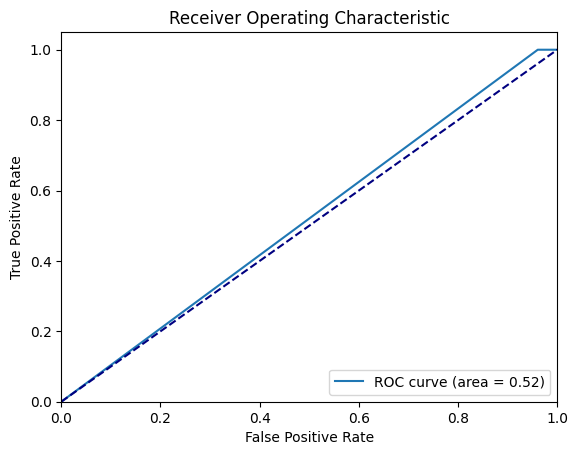

In [23]:
import joblib
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

if 'nvidia_gpu_temperature_celsius-max' not in prom_df.columns:
    prom_df['nvidia_gpu_temperature_celsius-max'] = 0
feature_cols = [col for col in prom_df.columns if col != 'isAnomaly']

iforest = joblib.load('r14n17_iforest_model.joblib')

pred = iforest.predict(prom_df[feature_cols])

pred_labels = [1 if i == -1 else 0 for i in pred]

print(classification_report(prom_df['isAnomaly'], pred_labels))

conf_mat = confusion_matrix(prom_df['isAnomaly'], pred_labels)
print('Confusion matrix:\n', conf_mat)

roc_auc = roc_auc_score(prom_df['isAnomaly'], pred_labels)
print('ROC AUC Score:', roc_auc)

fpr, tpr, _ = roc_curve(prom_df['isAnomaly'], pred_labels)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('roc_curve_iforest_r14n17.pdf', format='pdf')

plt.show()


/home/wenjun/miniconda3/envs/python_env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.80      0.81      0.80     24560
           1       0.61      0.60      0.60     12286

    accuracy                           0.74     36846
   macro avg       0.70      0.70      0.70     36846
weighted avg       0.74      0.74      0.74     36846

Confusion matrix:
 [[19780  4780]
 [ 4907  7379]]
ROC AUC Score: 0.7029884522040128


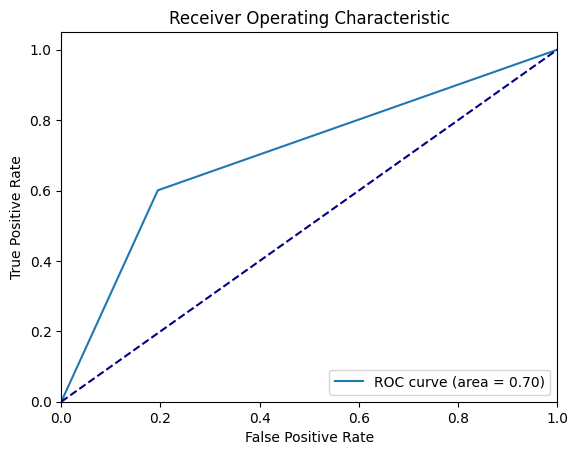

In [4]:
import joblib
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
prom_df = prom_df.drop('node', axis=1)

prom_df = prom_df.drop('timestamp', axis=1)

feature_cols = [col for col in prom_df.columns if col not in ['node', 'timestamp', 'isAnomaly','node_netstat_Udp_InErrors','node_netstat_Tcp_InErrs','node_netstat_Icmp_InErrors','node_filesystem_device_error-sum']]

iforest = IsolationForest(contamination=0.33)

iforest.fit(prom_df[feature_cols])

pred = iforest.predict(prom_df[feature_cols])

pred_labels = [1 if i == -1 else 0 for i in pred]

print(classification_report(prom_df['isAnomaly'], pred_labels))

conf_mat = confusion_matrix(prom_df['isAnomaly'], pred_labels)
print('Confusion matrix:\n', conf_mat)

roc_auc = roc_auc_score(prom_df['isAnomaly'], pred_labels)
print('ROC AUC Score:', roc_auc)

fpr, tpr, _ = roc_curve(prom_df['isAnomaly'], pred_labels)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


plt.show()


In [ ]:
import joblib
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

iforest = joblib.load('iforest_model.joblib')

prom_df = prom_df.drop('node', axis=1)
prom_df = prom_df.drop('timestamp', axis=1)

feature_cols = [col for col in prom_df.columns if col != 'isAnomaly']

pred = iforest.predict(prom_df[feature_cols])

pred_labels = [1 if i == -1 else 0 for i in pred]

print(classification_report(prom_df['isAnomaly'], pred_labels))

conf_mat = confusion_matrix(prom_df['isAnomaly'], pred_labels)
print('Confusion matrix:\n', conf_mat)

roc_auc = roc_auc_score(prom_df['isAnomaly'], pred_labels)
print('ROC AUC Score:', roc_auc)

fpr, tpr, _ = roc_curve(prom_df['isAnomaly'], pred_labels)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('roc_curve_iforest_r27n19.pdf', format='pdf')

plt.show()


In [7]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [8]:
import joblib


In [5]:
model_filename = 'r14n17_iforest_model.joblib'
joblib.dump(iforest, model_filename)

['r14n17_iforest_model.joblib']